In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [ ]:
df = pd.read_csv('1-data.csv')

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [ ]:
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36249 entries, 0 to 36248
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       36249 non-null  float64
 1   day        36249 non-null  int64  
 2   period     36249 non-null  float64
 3   nswprice   36249 non-null  float64
 4   nswdemand  36249 non-null  float64
 5   vicprice   36249 non-null  float64
 6   vicdemand  36249 non-null  float64
 7   transfer   36249 non-null  float64
 8   class      36249 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 2.5 MB


In [ ]:
class_proportion = df['class'].value_counts() / len(df)
round(class_proportion[1], 3)

0.425

Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

<Axes: >

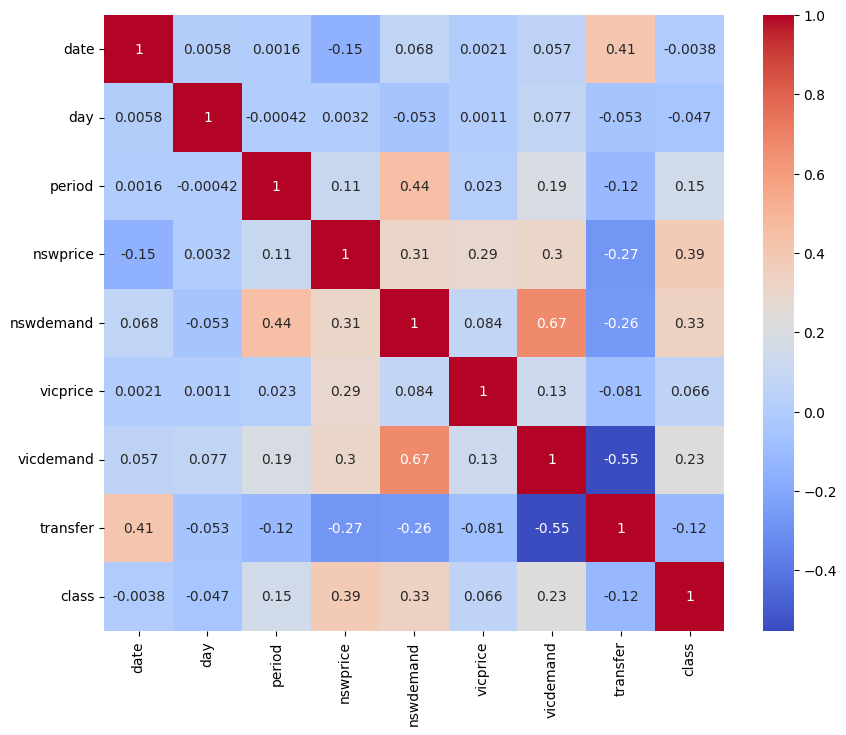

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [ ]:
max_corr = corr_matrix.abs().where(~np.eye(len(corr_matrix), dtype=bool)).max().max()
i, j = np.where(corr_matrix.abs() == max_corr)

print(corr_matrix.index[i[0]], corr_matrix.index[j[0]], sep=', ')

nswdemand, vicdemand


Постройте гистограммы распределений признаков.

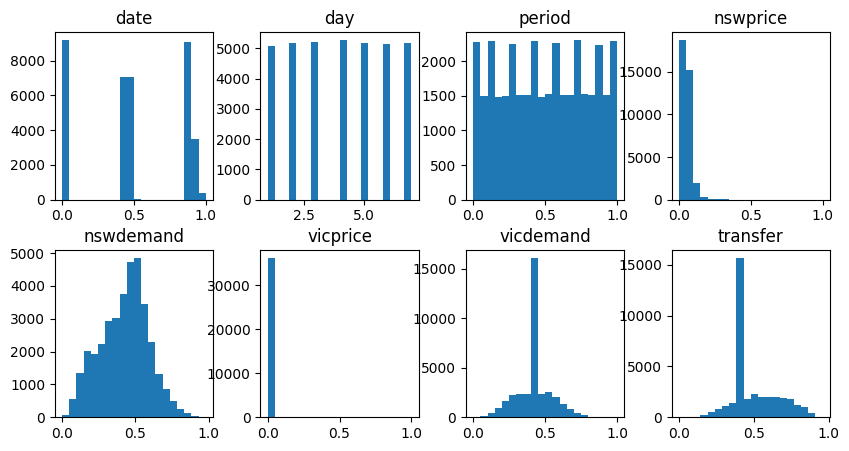

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, axi in enumerate(ax.flat):
    lbl = df.columns[i]
    axi.hist(df.iloc[:, i], bins=20)
    axi.set(title=lbl.split()[-1])

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [ ]:
X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании.

In [ ]:
les = RandomForestClassifier(random_state=21)
les.fit(X_train, y_train)

RandomForestClassifier(random_state=21)

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
predict_train = les.predict(X_train)
report = classification_report(y_train, predict_train, target_names = ['class 0', 'class 1'], digits=3)

In [ ]:
print(report)

              precision    recall  f1-score   support

     class 0      1.000     1.000     1.000     16699
     class 1      1.000     1.000     1.000     12300

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании.

Подбираемые параметры:

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [ ]:
params_grid = {'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}

grid = GridSearchCV(RandomForestClassifier(bootstrap=False, class_weight='balanced', n_jobs=-1, max_features='sqrt', random_state=21),
                    params_grid,
                    verbose=4,
                    cv=3)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   1.3s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   1.2s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.776 total time=   1.2s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.771 total time=   3.4s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.771 total time=   4.5s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.774 total time=   4.8s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.770 total time=   8.3s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.771 total time=  16.5s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.775 total time=  12.1s
[CV 1/3] END max_leaf_nodes=6

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1, random_state=21),
             param_grid={'max_leaf_nodes': [6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=4)

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели.

In [ ]:
grid.best_params_

{'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 100}

In [ ]:
best_les = grid.best_estimator_

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
predict_train = best_les.predict(X_train)
report = classification_report(y_train, predict_train, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.783     0.876     0.827     16699
     class 1      0.800     0.670     0.729     12300

    accuracy                          0.789     28999
   macro avg      0.791     0.773     0.778     28999
weighted avg      0.790     0.789     0.785     28999



Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [ ]:
prediction = best_les.predict(X_test)
report = classification_report(y_test, prediction, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.780     0.870     0.822      4161
     class 1      0.793     0.669     0.726      3089

    accuracy                          0.784      7250
   macro avg      0.786     0.770     0.774      7250
weighted avg      0.785     0.784     0.781      7250



От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [ ]:
important = best_les.feature_importances_

index = np.where(important == max(important))
feature = df.columns[index][0]
print(feature)

nswprice


Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [ ]:
estimators = [('logistic', LogisticRegression(solver='liblinear', random_state=21)),
              ('svm', SVC(random_state=21)),
               ('sgdc',SGDClassifier(random_state=21))]

vc = VotingClassifier(estimators=estimators, voting='hard')
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(random_state=21,
                                                 solver='liblinear')),
                             ('svm', SVC(random_state=21)),
                             ('sgdc', SGDClassifier(random_state=21))])

Вычислите точность модели на **тренировочных данных**

In [ ]:
predict_train = vc.predict(X_train)
report = classification_report(y_train, predict_train, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.733     0.899     0.808     16699
     class 1      0.802     0.555     0.656     12300

    accuracy                          0.753     28999
   macro avg      0.767     0.727     0.732     28999
weighted avg      0.762     0.753     0.743     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
prediction = vc.predict(X_test)
report = classification_report(y_test, prediction, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.730     0.888     0.801      4161
     class 1      0.788     0.557     0.652      3089

    accuracy                          0.747      7250
   macro avg      0.759     0.723     0.727      7250
weighted avg      0.754     0.747     0.738      7250



# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
bag = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'),
                        max_samples=0.5,
                        max_features=0.5,
                        bootstrap=False,
                        random_state=21)

bag.fit(X_train, y_train)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_features=0.5, max_samples=0.5, random_state=21)

Вычислите точность модели на **тренировочных данных**

In [ ]:
predict_train = bag.predict(X_train)
report = classification_report(y_train, predict_train, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.974     0.992     0.983     16699
     class 1      0.989     0.964     0.977     12300

    accuracy                          0.980     28999
   macro avg      0.982     0.978     0.980     28999
weighted avg      0.981     0.980     0.980     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
prediction = bag.predict(X_test)
report = classification_report(y_test, prediction, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.861     0.927     0.893      4161
     class 1      0.891     0.798     0.842      3089

    accuracy                          0.872      7250
   macro avg      0.876     0.863     0.868      7250
weighted avg      0.874     0.872     0.871      7250



# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
gbs = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=21, max_depth=2)
gbs.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.8, max_depth=2, n_estimators=500,
                           random_state=21)

Вычислите точность модели на **тренировочных данных**

In [ ]:
predict_train = gbs.predict(X_train)
report = classification_report(y_train, predict_train, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.936     0.945     0.941     16699
     class 1      0.925     0.912     0.919     12300

    accuracy                          0.931     28999
   macro avg      0.931     0.929     0.930     28999
weighted avg      0.931     0.931     0.931     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
prediction = gbs.predict(X_test)
report = classification_report(y_test, prediction, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.907     0.911     0.909      4161
     class 1      0.879     0.874     0.877      3089

    accuracy                          0.895      7250
   macro avg      0.893     0.892     0.893      7250
weighted avg      0.895     0.895     0.895      7250



# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
                          n_estimators=300,
                          learning_rate=0.5,
                          random_state=21)

ada.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=3),
                   learning_rate=0.5, n_estimators=300, random_state=21)

Вычислите точность модели на **тренировочных данных**

In [ ]:
predict_train = ada.predict(X_train)
report = classification_report(y_train, predict_train, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.963     0.935     0.949     16699
     class 1      0.915     0.951     0.933     12300

    accuracy                          0.942     28999
   macro avg      0.939     0.943     0.941     28999
weighted avg      0.943     0.942     0.942     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
prediction = ada.predict(X_test)
report = classification_report(y_test, prediction, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.925     0.897     0.911      4161
     class 1      0.867     0.902     0.884      3089

    accuracy                          0.899      7250
   macro avg      0.896     0.900     0.897      7250
weighted avg      0.900     0.899     0.899      7250



# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [ ]:
base = [('les', RandomForestClassifier(random_state=21)),
         ('svm', SVC(random_state=21))]
boss = LogisticRegression(random_state=21)

stack = StackingClassifier(base, boss)
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('les', RandomForestClassifier(random_state=21)),
                               ('svm', SVC(random_state=21))],
                   final_estimator=LogisticRegression(random_state=21))

Вычислите точность модели на **тренировочных данных**

In [ ]:
predict_train = stack.predict(X_train)
report = classification_report(y_train, predict_train, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.999     1.000     1.000     16699
     class 1      1.000     0.999     1.000     12300

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
prediction = stack.predict(X_test)
report = classification_report(y_test, prediction, target_names = ['class 0', 'class 1'], digits=3)
print(report)

              precision    recall  f1-score   support

     class 0      0.914     0.922     0.918      4161
     class 1      0.894     0.883     0.888      3089

    accuracy                          0.906      7250
   macro avg      0.904     0.903     0.903      7250
weighted avg      0.905     0.906     0.905      7250

